<a href="https://colab.research.google.com/github/anasbinayub/Cat-Vs-Dog-Prediction/blob/main/Cat_Vs_Dog_prediction_using_Deep_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
import os
from PIL import Image
import random

In [ ]:
from google.colab import drive
print("Mounting Google Drive to access the dataset...")
drive.mount('/content/drive')
print("Google Drive mounted successfully!")

Mounting Google Drive to access the dataset...
Mounted at /content/drive
Google Drive mounted successfully!


In [ ]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
print("Random seeds set for reproducibility.")

Random seeds set for reproducibility.


# Configure device (use GPU if available, else CPU)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Define transforms with reduced image size for faster processing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 64x64 images for faster processing
    transforms.RandomHorizontalFlip(),  # Augmentation: random horizontal flip
    transforms.RandomRotation(15),  # Augmentation: random rotation up to 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])
print("Image transformations defined with 224x224 resolution.")

Image transformations defined with 224x224 resolution.


# Unzip the dataset

In [ ]:
import zipfile

drive_data_path = '/content/drive/MyDrive/Dataset/PetImages.zip'
local_data_dir = '/content/PetImages'

# Check if the unzipped directory already exists to avoid unzipping again
if not os.path.exists(local_data_dir):
    print(f"Unzipping dataset to: {local_data_dir}")
    with zipfile.ZipFile(drive_data_path, 'r') as zip_ref:
        zip_ref.extractall('/content/')
    print("Dataset unzipped successfully!")
else:
    print(f"Dataset already unzipped in: {local_data_dir}")

Unzipping dataset to: /content/PetImages
Dataset unzipped successfully!


# Custom ImageFolder class to filter out corrupted images


In [ ]:
class FilteredImageFolder(ImageFolder):
    def __init__(self, root, transform=None, max_per_class=5000):
        super(FilteredImageFolder, self).__init__(root, transform=transform)
        print("Checking for corrupted images and limiting to 5,000 images per class...")
        self.samples = self._filter_and_limit_images(max_per_class)
        print(f"Found {len(self.samples)} valid images (max {max_per_class} per class).")

    def _filter_and_limit_images(self, max_per_class):
        valid_samples = []
        class_counts = {0: 0, 1: 0}  # Track counts for Cat (0) and Dog (1)
        class_names = {0: 'Cat', 1: 'Dog'}

        # Group samples by class
        class_to_samples = {0: [], 1: []}
        for path, target in self.samples:
            class_to_samples[target].append((path, target))

        # Shuffle samples to ensure random selection
        for target in class_to_samples:
            random.shuffle(class_to_samples[target])

        # Select up to max_per_class valid images per class
        for target in class_to_samples:
            for path, _ in class_to_samples[target]:
                if class_counts[target] >= max_per_class:
                    continue
                try:
                    if os.path.getsize(path) > 0:  # Check for empty files
                        with Image.open(path) as img:
                            img.verify()  # Verify image integrity
                        valid_samples.append((path, target))
                        class_counts[target] += 1
                    else:
                        print(f"Skipping empty image: {path}")
                except (IOError, SyntaxError):
                    print(f"Skipping corrupted image: {path}")

        # Print class counts
        for target, count in class_counts.items():
            print(f"Selected {count} images for class {class_names[target]}")
        return valid_samples


# Load dataset

In [ ]:
# Load dataset from local storage, limiting to 5,000 images per class
print(f"Loading dataset from: {local_data_dir}")
dataset = FilteredImageFolder(root=local_data_dir, transform=transform, max_per_class=5000)
print(f"Total images in dataset: {len(dataset)}")

Loading dataset from: /content/PetImages
Checking for corrupted images and limiting to 5,000 images per class...
Skipping empty image: /content/PetImages/Cat/666.jpg
Skipping empty image: /content/PetImages/Dog/11702.jpg
Selected 5000 images for class Cat
Selected 5000 images for class Dog
Found 10000 valid images (max 5000 per class).
Total images in dataset: 10000


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


# Split dataset into 80% train and 20% test


In [ ]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_indices, test_indices = torch.utils.data.random_split(range(len(dataset)), [train_size, test_size])
print(f"Training set size: {train_size}, Test set size: {test_size}")

Training set size: 8000, Test set size: 2000


# Create subsets for train and test

In [ ]:
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

# Create data loaders for batch processing


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
print("Data loaders created with batch_size=64 and num_workers=4 for faster processing.")

Data loaders created with batch_size=64 and num_workers=4 for faster processing.


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Define a simple Convolutional Neural Network (CNN) for classification

In [ ]:
class CatDogCNN(nn.Module):
    def __init__(self):
        super(CatDogCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)   # (3 → 32)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # (32 → 64)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # (64 → 128)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # (128 → 256)
        self.bn4 = nn.BatchNorm2d(256)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # (256 → 512)
        self.bn5 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(2, 2)
        # Corrected input features for the first fully connected layer
        self.fc1 = nn.Linear(512 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)  # Output: 2 classes (Cat, Dog)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.4)
        self.dropout2 = nn.Dropout(0.3)

        print("Deep 5-layer CNN model initialized.")

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = self.pool(self.relu(self.bn5(self.conv5(x))))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Initialize model, loss function, and optimizer


In [ ]:
model = CatDogCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
print("Model, loss function, and optimizer initialized.")

# Training loop with fewer epochs
num_epochs = 20
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
print(f"Starting training for {num_epochs} epochs...")

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        # Print labels shape for debugging
        print(f"Labels shape from loader: {labels.shape}")

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if batch_idx % 50 == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}")

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Test evaluation
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = test_loss / len(test_loader)
    test_acc = 100 * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

    # Step the scheduler
    scheduler.step()

print("Training completed!")

Deep 5-layer CNN model initialized.
Model, loss function, and optimizer initialized.
Starting training for 20 epochs...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Labels shape from loader: torch.Size([64])
Epoch 1, Batch 0, Loss: 0.6978
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shap

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shap

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shap

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Epoch 4, Batch 100, Loss: 0.6890
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loa

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Epoch 5, Batch 100, Loss: 0.5883
Labels shape from loa

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shap

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Epoch 7, Batch 50, Loss: 0.4282
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from load

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shap

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shap

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Epoch 10, Batch 100, Loss: 0.3507
Labels shape from loader: torch.Size([64])
Labels shape from lo

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Epoch 11, Batch 100, Loss: 0.4429
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from lo

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Epoch 12, Batch 50, Loss: 0.4744
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loa

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shap

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shap

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Labels shape from loader: torch.Size([64])
Epoch 15, Batch 0, Loss: 0.4260
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from load

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Labels shape from loader: torch.Size([64])
Epoch 16, Batch 100, Loss: 0.5015
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from lo

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Epoch [17/20], Train Loss: 0.4175, Train Acc: 81.94%, Test Loss: 0.3680, Test Acc: 84.05%
Labels shape from loader: torch.Size([64])
Epoch 1

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Epoch 18, Batch 100, Loss: 0.5371
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from lo

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Epoch 19, Batch 100, Loss: 0.4293
Labels shape from loader: torch.Size([64])
Labels shape from lo

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Epoch 20, Batch 50, Loss: 0.4019
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loader: torch.Size([64])
Labels shape from loa

# Plot training and test loss/accuracy

Generating loss and accuracy plots...


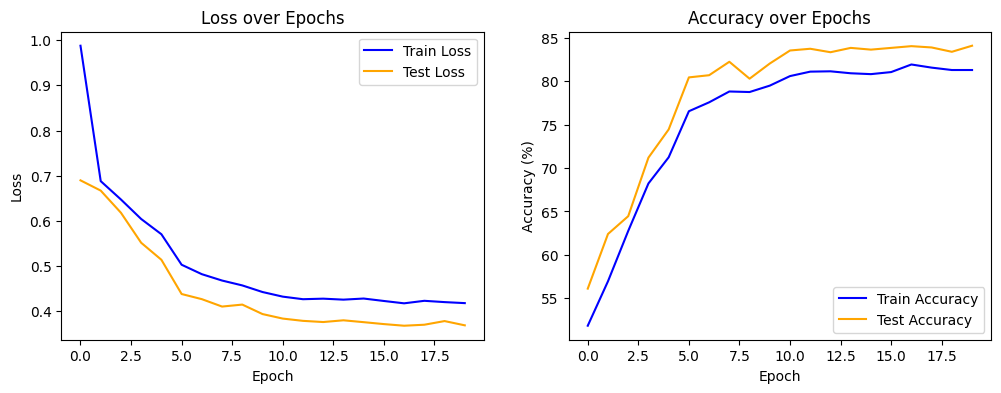

Plots displayed.


In [ ]:
print("Generating loss and accuracy plots...")
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(test_losses, label='Test Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(test_accuracies, label='Test Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()
print("Plots displayed.")

# Visualize sample predictions from test set


Visualizing sample test predictions...


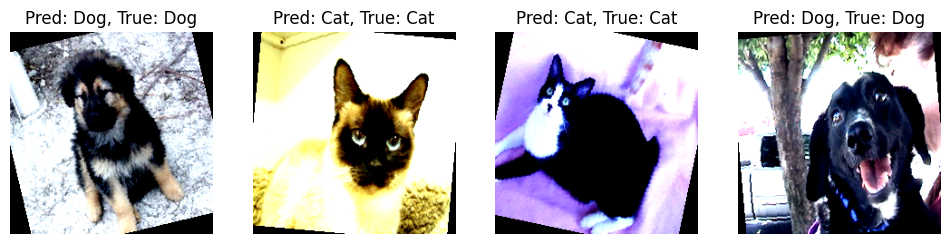

Sample predictions displayed.


In [ ]:
def imshow(img, title):
    img = img / 2 + 0.5  # Unnormalize image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert from CHW to HWC format
    plt.title(title)
    plt.axis('off')

print("Visualizing sample test predictions...")
model.eval()
sample_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)
images, labels = next(iter(sample_loader))
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

class_names = dataset.classes  # ['Cat', 'Dog']
fig = plt.figure(figsize=(12, 3))
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1)
    imshow(images[i].cpu(), f'Pred: {class_names[predicted[i]]}, True: {class_names[labels[i]]}')
plt.show()
print("Sample predictions displayed.")